# ***Fake News Detection*** – Machine Learning

## ***Data Preprocessing***

We will process data in different ways since traditional ML and transformers handle text differently. Specifically, ML models need more cleeaning and normalization, we will lowercase text, strip numbers, we will remove stop words and lemmatize. DL models work well with raw text, so we will remove only noisy content.

In [62]:
import os
import re
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Span, DocBin
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from scipy.sparse import hstack

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import time
from tqdm import tqdm
import optuna
from optuna.integration import OptunaSearchCV
import joblib

from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import classification_report

We will import some customs utilities for data preprocessing

In [63]:
import importlib

sys.path.append(os.path.abspath(os.getcwd()))

import utils.data_preprocess

importlib.reload(utils.data_preprocess)

from utils.data_preprocess import (
    prepare_numeric_features,
    run_full_pipeline,
    PrepareNumericFeatures,
)

In [64]:
SEED = 13

### ***1. Dataset Preparation***
We load the preprocessed fake news dataset and perform initial cleaning. This includes removing unnecessary columns, duplicates, and preparing a smaller sample for faster experimentation.

Explicitly setting `dtype={6: str, 7: str}` ensures that columns 6 and 7 (typically `title` and `text`)
are read as strings, preventing potential issues with mixed types.

In [65]:
news_data = pd.read_csv("dataset/news_data.csv", dtype={6: str, 7: str})

In [66]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
news_data.describe(include="all")

title  \
count                                               38310   
unique                                              37935   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   14   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                                     text       subject  \
count                                               38310         38310   
unique                                              38310             7   
top     The head of a conservative Republican faction ...  politicsNews   
freq                                                    1         11212   
mean                                                  NaN           NaN   
std                                                   NaN           NaN   
min                                                   NaN           NaN   
25%                                                   NaN           NaN   
50%                                                   NaN           NaN   
75%                                                   NaN           NaN   
max                                                   NaN           NaN   

              date          fake  \
count        31759  38310.000000   
unique         761           NaN   
top     2017-12-06           NaN   
freq           169           NaN   
mean           NaN      0.446881   
std            NaN      0.497177   
min            NaN      0.000000   
25%            NaN      0.000000   
50%            NaN      0.000000   
75%            NaN      1.000000   
max            NaN      1.000000   

                                            original_text       place  \
count                                               38310       19572   
unique                                              38310        1612   
top     WASHINGTON (Reuters) - The head of a conservat...  WASHINGTON   
freq                                                    1        6412   
mean                                                  NaN         NaN   
std                                                   NaN         NaN   
min                                                   NaN         NaN   
25%                                                   NaN         NaN   
50%                                                   NaN         NaN   
75%                                                   NaN         NaN   
max                                                   NaN         NaN   

       broadcaster  title_length   text_length  title_sentiment  \
count        21032  38310.000000  38310.000000     38310.000000   
unique           4           NaN           NaN              NaN   
top        Reuters           NaN           NaN              NaN   
freq         21021           NaN           NaN              NaN   
mean           NaN     11.907961    404.731637        -0.111406   
std            NaN      3.646243    313.069716         0.414864   
min            NaN      1.000000     19.000000        -0.974900   
25%            NaN      9.000000    220.000000        -0.446600   
50%            NaN     11.000000    369.000000         0.000000   
75%            NaN     14.000000    512.000000         0.077200   
max            NaN     42.000000   8135.000000         0.950300   

        text_sentiment  flesch_kincaid_grade  flesch_reading_ease  \
count     38310.000000          38310.000000         38310.000000   
unique             NaN                   NaN                  NaN   
top                NaN                   NaN                  NaN   
freq               NaN     

We will now remove redundant or non-predictive columns

In [67]:
columns_to_drop = [
    "title",
    "text",
    "subject",
    "original_text",
    "place",
    "broadcaster",
    "title_cleaned",
    "combined_text",
]

news_data = news_data.drop(columns=columns_to_drop)

We see that after cleaning the number of unique values for `clean_text` differ from the total, we have created duplicates that we have to remove.

In [68]:
duplicate_rows = news_data.duplicated(subset=["clean_text"])
print(f"Found {duplicate_rows.sum()} duplicate rows.")

news_data = news_data.drop_duplicates(subset=["clean_text"], keep="first")

Found 19 duplicate rows.


We will drop news not having a valid date

In [69]:
news_data = news_data.dropna(subset=['date']).copy()

We used a 10% sample of the dataset to speed up the process during early stages.

In [ ]:
news_data_ml, _ = train_test_split(
    news_data, test_size=0.9, stratify=news_data["fake"], random_state=SEED
)

### ***2. Text Normalization for ML Models***
We apply spaCy-based NLP preprocessing (lemmatization, entity masking, lowercasing, etc.) to transform raw news content into normalized text suitable for traditional ML models.

We start with defining terms to mask with placeholders.

In [70]:
DIGIT_PATTERN = re.compile(r"\d+")
PUNCT_PATTERN = re.compile(r"[^\w\s]")

# Define terms to mask
event_terms = {
    "election",
    "campaign",
    "trump campaign",
    "affordable care act",
    "black lives matter",
    "presidential election",
    "election fraud",
}
platform_terms = {"twitter", "facebook", "youtube"}
content_terms = {
    "video",
    "image",
    "photo",
    "pic",
    "screen capture",
    "featured image",
    "video screen capture",
    "image video screen",
}
source_terms = {
    "fox news",
    "new york times",
    "21st century wire",
    "reuters",
    "told reuters",
    "news 21st century",
}

Then we set up a custom `spaCy` **NLP** pipeline that tags specific words or phrases as custom entities like "EVENT" or "PLATFORM" based on predefined term lists.

In [71]:
def setup_nlp_pipeline():
    nlp = spacy.load("en_core_web_sm")
    patterns = []

    def make_token_pattern(phrase):
        return [{"LOWER": token} for token in phrase.lower().split()]

    for term in event_terms:
        patterns.append({"label": "EVENT", "pattern": make_token_pattern(term)})
    for term in platform_terms:
        patterns.append({"label": "PLATFORM", "pattern": make_token_pattern(term)})
    for term in content_terms:
        patterns.append({"label": "CONTENT", "pattern": make_token_pattern(term)})
    for term in source_terms:
        patterns.append({"label": "SOURCE", "pattern": make_token_pattern(term)})

    ruler = nlp.add_pipe("entity_ruler", before="ner")
    ruler.add_patterns(patterns)

    return nlp


nlp = setup_nlp_pipeline()

Now we define the function to process the text substitution and the lemmatization.

In [72]:
def process_text(text):
    """Process a single text with entity masking and lemmatization"""

    if text is None or not isinstance(text, str):
        return ""

    text = str(text).strip()
    if not text:
        return ""

    text = re.sub(r"[\[\]\(\)]", " ", text)

    doc = nlp(text)

    masked_text = text
    offsets = []

    for ent in doc.ents:
        label = ent.label_
        replacement = None

        if label == "PERSON":
            replacement = "_person_"
        elif label in ["GPE", "LOC"]:
            replacement = "_location_"
        elif label == "ORG":
            replacement = "_organization_"
        elif label == "DATE":
            replacement = "_date_"
        elif label == "EVENT":
            replacement = "_event_"
        elif label == "PLATFORM":
            replacement = "_platform_"
        elif label == "CONTENT":
            replacement = "_content_"
        elif label == "SOURCE":
            replacement = "_source_"

        if replacement:
            offsets.append((ent.start_char, ent.end_char, replacement))

    # Sort entities in reverse order to replace from end to beginning
    offsets.sort(key=lambda x: x[0], reverse=True)

    # Replace entities with masks
    for start, end, replacement in offsets:
        masked_text = masked_text[:start] + replacement + masked_text[end:]

    # Clean: lowercase, remove numbers/punctuation
    cleaned_text = masked_text.lower()
    cleaned_text = DIGIT_PATTERN.sub("", cleaned_text)
    cleaned_text = PUNCT_PATTERN.sub(" ", cleaned_text)

    # Get lemmas and filter stopwords
    cleaned_doc = nlp(cleaned_text)
    lemmas = [
        token.lemma_
        for token in cleaned_doc
        if token.text.lower() not in STOP_WORDS and token.lemma_.strip()
    ]

    # Join lemmas and clean up
    processed_text = " ".join(lemmas)

    # Remove any remaining 'sep' artifacts
    processed_text = re.sub(
        r"_ (person|location|organization|date|event|platform|content|source) _",
        r"_\1_",
        processed_text,
    )
    processed_text = re.sub(r"\bsep\b", "", processed_text)
    processed_text = re.sub(r"\s+", " ", processed_text).strip()

    return processed_text

We will process the news in batches

In [73]:
from tqdm import tqdm


def mask_batch(texts, batch_size=100):
    """Process texts in smaller batches to avoid memory issues"""
    results = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Masking Batches"):
        batch = texts[i : i + batch_size]
        batch_results = [process_text(text) for text in batch]
        results.extend(batch_results)

    return results

In [19]:
news_data_ml["lemmatized_text"] = mask_batch(news_data_ml["clean_text"].tolist())

Masking Batches: 100%|██████████| 39/39 [09:35<00:00, 14.76s/it]


In [86]:
news_data["lemmatized_text"] = mask_batch(news_data["clean_text"].tolist())

Masking Batches: 100%|██████████| 318/318 [1:18:53<00:00, 14.88s/it]


Here is a sample after the process.

In [87]:
print("Sample generalized text:", news_data["lemmatized_text"].sample(10))

Sample generalized text: 22033    _source_ share poll trump go hate meltdown ine...
18773    world _location_ _location_ s opposition party...
2122     internet firm shift stance exile white suprema...
9509     senator _person_ bill block _organization_ hac...
631      _person_ urge _organization_ halt quest _locat...
13891    _location_ _location_ ink rohingya return deal...
4510     _organization_ say new trade order set stage m...
23732    internet love trump embarrassingly awkward han...
25840    watch _person_ get catch lie defend roger aile...
18416    _location_ say potential voting station catala...
Name: lemmatized_text, dtype: object


***Clipping***

Now we will clip the text to 500 words to reduce computational cost and maintain consistent input size for models. Then we will save the result.

In [88]:
def clip_text(text, max_words=500):
    """
    Clips text to a maximum of `max_words`.
    - Keeps only the first `max_words` words.
    """
    return " ".join(text.split()[:max_words])

In [ ]:
news_data_ml["clipped"] = news_data_ml["lemmatized_text"].apply(
    lambda x: clip_text(x, max_words=500)
)

In [89]:
news_data["clipped"] = news_data["lemmatized_text"].apply(
    lambda x: clip_text(x, max_words=500)
)
news_data.to_csv("dataset/news_data_clip.csv", index=False)

In [90]:
news_data = pd.read_csv("dataset/news_data_clip.csv")

### ***3. Splitting & Feature Engineering***
We split the normalized dataset into train, validation, and test sets using stratified sampling to preserve class balance. Then, we build a combined feature pipeline using TF-IDF vectorization and numerical feature extraction through custom transformers.


In [ ]:
news_data = news_data.sort_values('date').reset_index(drop=True)

In [91]:
def chronological_split_with_refinements(
    df,
    date_col='date',
    label_col='label',
    train_frac=0.70,
    val_frac=0.15,
    test_frac=0.15,
    min_train_days=30,
    min_val_days=15,
    min_test_days=15,
    random_state=42
):
    """
    Sorts 'df' by 'date_col' in ascending order, then splits it into
    train, val, test by fraction. Tries to ensure each subset covers
    at least some minimal range of days. If that minimal coverage is
    not satisfied, the code will adjust cutoffs.

    Arguments:
    ---------
      df: pd.DataFrame
      date_col: str
        Column name of the datetime field
      label_col: str
        Name of the binary label column
      train_frac, val_frac, test_frac: floats
        Fractions for splitting, must sum to 1.0
      min_train_days, min_val_days, min_test_days: int
        Minimum timespan (in days) to ensure each split covers
      random_state: int
        For reproducible sampling if you do balancing

    Returns:
    --------
      train_df, val_df, test_df: pd.DataFrames
        Chronologically split. The code attempts to ensure each
        subset spans at least the requested number of days.
    """
    # 1) Convert date_col to datetime, drop invalid
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col]).copy()
    df = df.sort_values(date_col).reset_index(drop=True)

    # 2) Basic fraction-based row indices
    n = len(df)
    if n == 0:
        raise ValueError("No data left after dropping rows with invalid dates!")
    train_end_idx = int(train_frac * n)
    val_end_idx   = int((train_frac + val_frac) * n)

    # 3) Identify the naive cut dates
    train_end_date = df.loc[train_end_idx - 1, date_col] if train_end_idx > 0 else df.loc[0, date_col]
    val_end_date   = df.loc[val_end_idx - 1, date_col] if val_end_idx > 0 else df.loc[0, date_col]

    # 4) Create an initial fraction-based split
    train_df = df[df[date_col] <= train_end_date]
    remainder_df = df[df[date_col] > train_end_date]
    val_df = remainder_df[remainder_df[date_col] <= val_end_date]
    test_df = remainder_df[remainder_df[date_col] > val_end_date]

    # 5) Check timespans for each set
    #    (if you want to refine automatically, do so here)
    def date_span_days(subset):
        if len(subset) == 0:
            return 0
        return (subset[date_col].iloc[-1] - subset[date_col].iloc[0]).days

    tspan_train = date_span_days(train_df)
    tspan_val   = date_span_days(val_df)
    tspan_test  = date_span_days(test_df)

    print(f"Initial fraction-based split => Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    print(f"Timespans (days) => Train: {tspan_train}, Val: {tspan_val}, Test: {tspan_test}")

    # 6) If a subset doesn't meet minimal days, you *can* auto-adjust
    #    For example, if train_df is too short in timespan, we might
    #    expand it forward or handle it differently.  The logic below
    #    is just a naive example:
    if tspan_train < min_train_days and len(val_df) > 0:
        # expand train up to where we get min_train_days
        needed_end_date = train_df[date_col].iloc[0] + pd.Timedelta(days=min_train_days)
        train_df = df[df[date_col] <= needed_end_date]
        remainder_df = df[df[date_col] > needed_end_date]
        val_df = remainder_df[remainder_df[date_col] <= val_end_date]  # reapply val_end_date
        test_df = remainder_df[remainder_df[date_col] > val_end_date]
    
    # You can do similar expansions for val/test if they're too short

    # Recompute timespans
    tspan_train = date_span_days(train_df)
    tspan_val   = date_span_days(val_df)
    tspan_test  = date_span_days(test_df)

    print("\nAfter minimal timespan refinements:")
    print(f"Train: {len(train_df)} rows, covers {tspan_train} days  "
          f"({train_df[date_col].iloc[0]} to {train_df[date_col].iloc[-1]})")
    print(f"Val:   {len(val_df)} rows, covers {tspan_val} days    "
          f"({val_df[date_col].iloc[0] if len(val_df)>0 else 'N/A'} to {val_df[date_col].iloc[-1] if len(val_df)>0 else 'N/A'})")
    print(f"Test:  {len(test_df)} rows, covers {tspan_test} days   "
          f"({test_df[date_col].iloc[0] if len(test_df)>0 else 'N/A'} to {test_df[date_col].iloc[-1] if len(test_df)>0 else 'N/A'})")

    return train_df, val_df, test_df

In [92]:
def oversample_minority(df, label_col='label', random_state=42):
    """
    Randomly oversample the minority class to match the majority class size.
    Only to be used on the training set to mitigate label imbalance.
    """
    df_majority = df[df[label_col] == 0]
    df_minority = df[df[label_col] == 1]

    if len(df_minority) < len(df_majority):
        df_minority_upsampled = resample(
            df_minority,
            replace=True,
            n_samples=len(df_majority),
            random_state=random_state
        )
        df_balanced = pd.concat([df_majority, df_minority_upsampled])
    else:
        df_majority_upsampled = resample(
            df_majority,
            replace=True,
            n_samples=len(df_minority),
            random_state=random_state
        )
        df_balanced = pd.concat([df_minority, df_majority_upsampled])

    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df_balanced

In [93]:
train_df, val_df, test_df = chronological_split_with_refinements(
    news_data,
    date_col='date',
    label_col='fake',
    train_frac=0.70,
    val_frac=0.15,
    test_frac=0.15,
    min_train_days=60,  # require at least 2 months coverage for train
    min_val_days=30,
    min_test_days=30,
    random_state=SEED
)

Initial fraction-based split => Train: 22332, Val: 4786, Test: 4622
Timespans (days) => Train: 879, Val: 43, Test: 51

After minimal timespan refinements:
Train: 22332 rows, covers 879 days  (2015-05-01 00:00:00 to 2017-09-26 00:00:00)
Val:   4786 rows, covers 43 days    (2017-09-27 00:00:00 to 2017-11-09 00:00:00)
Test:  4622 rows, covers 51 days   (2017-11-10 00:00:00 to 2017-12-31 00:00:00)


If the training set is extremely imbalanced, oversample only the training portion

In [94]:
train_data = oversample_minority(train_df, label_col='fake', random_state=SEED)
val_data = val_df 
test_data = test_df

In [95]:
# news_data = news_data.sample(frac=1, random_state=SEED).reset_index(drop=True)
# train_data, temp_data = train_test_split(
#     news_data, test_size=0.3, stratify=news_data["fake"], random_state=SEED
# )
# val_data, test_data = train_test_split(
#     temp_data, test_size=0.5, stratify=temp_data["fake"], random_state=SEED
# )

print(f"🔹 Train size: {len(train_data)} ({len(train_data)/len(news_data):.2%})")
print(f"🔹 Validation size: {len(val_data)} ({len(val_data)/len(news_data):.2%})")
print(f"🔹 Test size: {len(test_data)} ({len(test_data)/len(news_data):.2%})")

🔹 Train size: 24284 (76.51%)
🔹 Validation size: 4786 (15.08%)
🔹 Test size: 4622 (14.56%)


***Log Transform and Standardization***

We now handle the numeric features, if distribution is skewed we log transform and then we standardize.

In [96]:
prep = PrepareNumericFeatures()
X_train = prep.fit_transform(train_data)
X_val = prep.transform(val_data)
X_test = prep.transform(test_data)

y_train = train_data["fake"]
y_val = val_data["fake"]
y_test = test_data["fake"]

This is the list of the current numeric features

In [97]:
numeric_features = (
    X_train.select_dtypes(include=["number"]).drop(columns=["fake"]).columns.tolist()
)
print("Numeric features:", numeric_features)

Numeric features: ['title_length', 'title_sentiment', 'text_sentiment', 'flesch_kincaid_grade', 'flesch_reading_ease', 'has_video', 'has_audio', 'has_image', 'has_social', 'has_authority', 'log_text_length', 'log_clickbait_score', 'log_exclamation_count', 'log_question_count', 'log_uppercase_ratio', 'log_clickbaitiness_score']


Now we will initialize TF-IDF vectorizer with max 50k features

In [98]:
tfidf = TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_features=50000)

X_train_tfidf = tfidf.fit_transform(X_train["clipped"])
X_val_tfidf = tfidf.transform(X_val["clipped"])
X_test_tfidf = tfidf.transform(X_test["clipped"])

And we add numeric features

In [99]:
X_train_combined = hstack([X_train_tfidf, X_train[numeric_features].values])
X_val_combined = hstack([X_val_tfidf, X_val[numeric_features].values])
X_test_combined = hstack([X_test_tfidf, X_test[numeric_features].values])

We will reduce dimensionality with SVD to 300 and compare the model results 

In [100]:
svd = TruncatedSVD(n_components=300, random_state=SEED)
X_train_svd = svd.fit_transform(X_train_combined)
X_val_svd = svd.transform(X_val_combined)
X_test_svd = svd.transform(X_test_combined)

### ***4. Baseline Model Training***

We train a Logistic Regression model as a baseline on the combined feature set and evaluate its performance.

Train Logistic Regression on TF-IDF Features

In [101]:
logreg_tfidf = LogisticRegression(max_iter=1000, random_state=SEED)
logreg_tfidf.fit(X_train_combined, y_train)

y_val_pred_tfidf = logreg_tfidf.predict(X_val_combined)
accuracy_tfidf = accuracy_score(y_val, y_val_pred_tfidf)
f1_tfidf = f1_score(y_val, y_val_pred_tfidf)

Train Logistic Regression on SVD-Reduced Features

In [102]:
logreg_svd = LogisticRegression(max_iter=1000, random_state=SEED)
logreg_svd.fit(X_train_svd, y_train)

y_val_pred_svd = logreg_svd.predict(X_val_svd)
accuracy_svd = accuracy_score(y_val, y_val_pred_svd)
f1_svd = f1_score(y_val, y_val_pred_svd)

Compare Results

In [103]:
results_df = pd.DataFrame(
    {
        "Method": ["TF-IDF", "TF-IDF + SVD"],
        "Accuracy": [accuracy_tfidf, accuracy_svd],
        "F1-Score": [f1_tfidf, f1_svd],
    }
)

In [104]:
display(results_df)

Method  Accuracy  F1-Score
0        TF-IDF  0.996030  0.961924
1  TF-IDF + SVD  0.996239  0.963855

The numbers are identical, so reducing dimensionality is not degrading model performances.

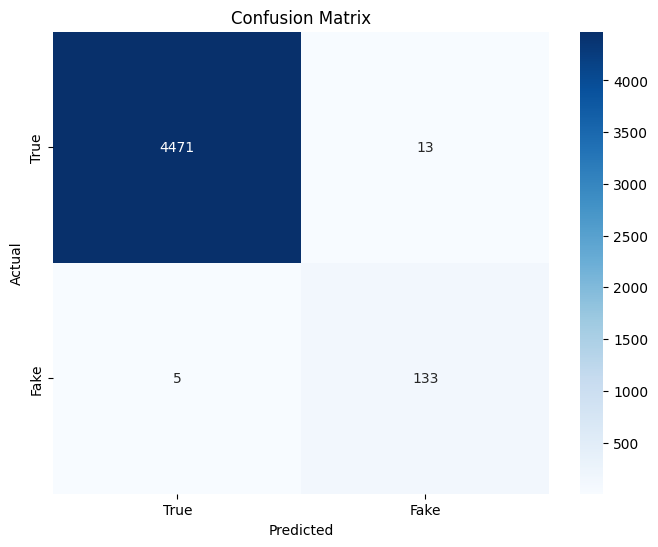

In [105]:
y_test_pred_tfidf = logreg_tfidf.predict(X_test_combined)
cm_tfidf = confusion_matrix(y_test, y_test_pred_tfidf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_tfidf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["True", "Fake"],
    yticklabels=["True", "Fake"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [106]:
report_dict = classification_report(y_test, y_test_pred_tfidf, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

print("Classification Report:")
display(report_df)

Classification Report:


precision  recall  f1-score   support
0                 0.999   0.997     0.998  4484.000
1                 0.911   0.964     0.937   138.000
accuracy          0.996   0.996     0.996     0.996
macro avg         0.955   0.980     0.967  4622.000
weighted avg      0.996   0.996     0.996  4622.000

***Features Importance***

We saw that the results are almost the same before and after dimensionality reduction, but is the same for features importance?

In [107]:
feature_importance_combined = np.abs(logreg_tfidf.coef_).flatten()
num_tfidf_features = X_train_tfidf.shape[1]
top_features_combined = np.argsort(feature_importance_combined)[-20:]

feature_names = []
feature_importances = []

for idx in top_features_combined:
    if idx < num_tfidf_features:
        feature_names.append(tfidf.get_feature_names_out()[idx])
    else:
        numeric_feature_idx = idx - num_tfidf_features
        feature_names.append(numeric_features[numeric_feature_idx])
    feature_importances.append(feature_importance_combined[idx])

importance_combined = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)
importance_combined = importance_combined.sort_values(by="Importance", ascending=False)

print("Top Feature Contributions only TF-IDF\n")
display(importance_combined)

Top Feature Contributions only TF-IDF



Feature  Importance
19       log_uppercase_ratio    7.214955
18                       say    5.355599
17                _location_    4.543047
16                    _date_    3.506391
15            _organization_    3.397380
14              _source_ say    3.012148
13                     trade    2.634898
12                      wire    2.596737
11                 _content_    2.415466
10                       edt    2.231377
9         _organization_ say    2.151567
8               _person_ say    2.132701
7              news _source_    2.079787
6           subscribe member    1.777250
5                  subscribe    1.756083
4       _location_ president    1.631244
3   _content_ _organization_    1.547177
2               say _person_    1.506681
1                 say _date_    1.488299
0                       like    1.442525

We verify the most important features after SVD for the first 3 components, the ones with larger variance.

In [108]:
def print_top_svd_features(
    svd, tfidf_vectorizer, numeric_feature_names, top_n=10, components=[0, 1, 2]
):
    """
    Print top contributing features for selected SVD components.

    Parameters:
    - svd: trained TruncatedSVD model
    - tfidf_vectorizer: fitted TfidfVectorizer
    - numeric_feature_names: list of numeric feature names
    - top_n: number of top features to show per component
    - components: list of component indices to display
    """
    feature_names = list(tfidf_vectorizer.get_feature_names_out()) + list(
        numeric_feature_names
    )
    svd_components = svd.components_

    print("Top Feature Contributions per SVD Component\n")

    for i in components:
        comp = svd_components[i]
        top_indices = np.argsort(np.abs(comp))[-top_n:][::-1]

        print(f"\nComponent {i+1} (Top {top_n} features):")
        for idx in top_indices:
            print(f" - {feature_names[idx]}: {comp[idx]:.4f}")

In [109]:
print_top_svd_features(
    svd=svd,
    tfidf_vectorizer=tfidf,
    numeric_feature_names=numeric_features,
    top_n=10,
    components=[0, 1, 2],
)

Top Feature Contributions per SVD Component


Component 1 (Top 10 features):
 - log_text_length: 0.7384
 - flesch_kincaid_grade: 0.4158
 - title_length: 0.3646
 - flesch_reading_ease: 0.3613
 - log_uppercase_ratio: 0.1281
 - title_sentiment: -0.0255
 - log_clickbait_score: 0.0198
 - log_clickbaitiness_score: 0.0131
 - log_question_count: 0.0123
 - has_video: 0.0122

Component 2 (Top 10 features):
 - log_clickbait_score: 0.4662
 - log_clickbaitiness_score: 0.4470
 - log_exclamation_count: 0.3823
 - flesch_kincaid_grade: -0.3676
 - log_uppercase_ratio: 0.3069
 - log_question_count: 0.2898
 - flesch_reading_ease: 0.2487
 - title_length: 0.1937
 - log_text_length: -0.0975
 - text_sentiment: -0.0740

Component 3 (Top 10 features):
 - flesch_kincaid_grade: 0.5769
 - flesch_reading_ease: -0.4515
 - log_clickbaitiness_score: 0.3269
 - log_clickbait_score: 0.3106
 - log_question_count: 0.2656
 - log_exclamation_count: 0.2350
 - log_uppercase_ratio: -0.2265
 - title_length: -0.1979
 - text_senti

After SVD the most relevant features seem to be the numeric ones, there are no words or placeholders from lemmatized clipped text.

### ***5. Advanced Model Benchmarking***

We will compare several traditional ML models, LogReg, SVM, Random Forest and LightGBM, tuning with Optuna.

In [111]:
models = {
    "LogisticRegression": Pipeline(
        [("clf", LogisticRegression(max_iter=1000, random_state=SEED))]
    ),
    "RandomForest": Pipeline([("clf", RandomForestClassifier(random_state=SEED))]),
    "SVM": Pipeline([("clf", SVC(probability=True, random_state=SEED))]),
    "LightGBM": Pipeline([("clf", LGBMClassifier(random_state=SEED, verbosity=-1))]),
}

We try to be quite thorough with hyperparameters but we still want to keep the process quick.

In [112]:
from optuna.distributions import (
    FloatDistribution,
    CategoricalDistribution,
    IntDistribution,
)

param_grids = {
    "LogisticRegression": {
        "clf__solver": CategoricalDistribution(["liblinear", "lbfgs"]),
        "clf__penalty": CategoricalDistribution(["l2"]),
        "clf__C": FloatDistribution(0.01, 100, log=True),
    },
    "RandomForest": {
        "clf__n_estimators": IntDistribution(100, 300, step=100),
        "clf__max_depth": CategoricalDistribution([None, 10, 20, 30]),
        "clf__min_samples_split": IntDistribution(2, 5),
        "clf__min_samples_leaf": IntDistribution(1, 2),
    },
    "SVM": {
        "clf__C": FloatDistribution(0.1, 10, log=True),
        "clf__kernel": CategoricalDistribution(["linear", "rbf", "poly"]),
        "clf__gamma": CategoricalDistribution(["scale", "auto"]),
    },
    "LightGBM": {
        "clf__n_estimators": IntDistribution(100, 300, step=100),
        "clf__learning_rate": FloatDistribution(0.01, 0.1, log=True),
        "clf__num_leaves": IntDistribution(15, 64),
        "clf__max_depth": IntDistribution(-1, 20),
    },
}

We will make use of Optuna with 3 folds using F1 score as a reference metrics.

In [113]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [114]:
results = []
conf_matrices = {}

f1_scorer = make_scorer(f1_score)

In [115]:
def tune_and_evaluate(name, model, param_dist):
    print(f"Tuning {name} with Optuna...")

    start_time = time.time()

    optuna_cv = OptunaSearchCV(
        estimator=model,
        param_distributions=param_dist,
        scoring=f1_scorer,
        cv=3,
        n_trials=15,
        n_jobs=-1,
        random_state=SEED,
        verbose=0,
    )

    X_train_df = pd.DataFrame(X_train_svd)
    X_val_df = pd.DataFrame(X_val_svd)

    optuna_cv.fit(X_train_df, y_train)

    elapsed = round(time.time() - start_time, 2)

    y_pred = optuna_cv.predict(X_val_df)
    report = classification_report(y_val, y_pred, output_dict=True)
    cm = confusion_matrix(y_val, y_pred)

    results.append(
        {
            "Model": name,
            "F1 Score": round(report["1"]["f1-score"], 3),
            "Accuracy": round(report["accuracy"], 3),
            "Precision": round(report["1"]["precision"], 3),
            "Recall": round(report["1"]["recall"], 3),
            "Training Time (s)": elapsed,
        }
    )

    conf_matrices[name] = cm

    joblib.dump(optuna_cv.best_estimator_, f"models/{name}_best_model.pkl")

In [116]:
for model_name, model in tqdm(models.items()):
    param_dist = param_grids[model_name]
    tune_and_evaluate(model_name, model, param_dist)

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\iceke\AppData\Local\Temp\ipykernel_11288\1661374080.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cv = OptunaSearchCV(


Tuning LogisticRegression with Optuna...


 25%|██▌       | 1/4 [01:04<03:14, 64.81s/it]C:\Users\iceke\AppData\Local\Temp\ipykernel_11288\1661374080.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cv = OptunaSearchCV(


Tuning RandomForest with Optuna...


 50%|█████     | 2/4 [20:29<23:43, 711.61s/it]C:\Users\iceke\AppData\Local\Temp\ipykernel_11288\1661374080.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cv = OptunaSearchCV(


Tuning SVM with Optuna...


 75%|███████▌  | 3/4 [1:03:48<26:13, 1573.65s/it]C:\Users\iceke\AppData\Local\Temp\ipykernel_11288\1661374080.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cv = OptunaSearchCV(


Tuning LightGBM with Optuna...


100%|██████████| 4/4 [1:07:42<00:00, 1015.53s/it]


In [117]:
results_df = pd.DataFrame(results)
results_df.to_csv("logs/model_results_optuna.csv", index=False)

Let's display and compare the results

In [118]:
print("Model Performance Summary:\n")
display(results_df.set_index("Model"))

Model Performance Summary:



F1 Score  Accuracy  Precision  Recall  Training Time (s)
Model                                                                       
LogisticRegression     0.984     0.998      0.968   1.000              64.63
RandomForest           0.881     0.987      0.804   0.975            1163.82
SVM                    0.980     0.998      0.960   1.000            2599.08
LightGBM               0.964     0.996      0.934   0.996             233.27

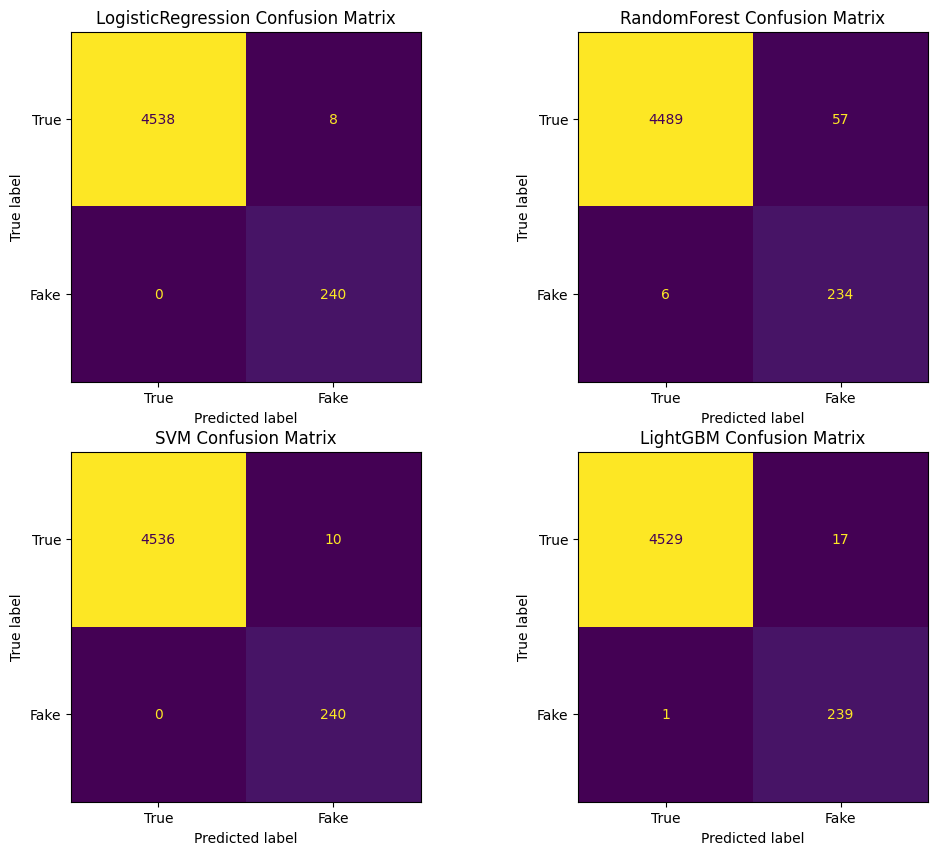

In [119]:
num_models = len(conf_matrices)
cols = 2
rows = (num_models + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()

for idx, (model_name, cm) in enumerate(conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "Fake"])
    disp.plot(ax=axes[idx], values_format="d", colorbar=False)
    axes[idx].set_title(f"{model_name} Confusion Matrix")

These confusion matrices show that Logistic Regression and SVM are the most precise models, with almost perfect classification and very few mistakes on either class. LightGBM is also quite accurate but has slightly more misclassifications. Random Forest is not performing like the others, misclassifying a larger number of fake news as true, which suggests it might struggle more with separating nuanced patterns in the data.

In [21]:
best_model = joblib.load("models/LogisticRegression_best_model.pkl")

Now we will predict on test dataset

In [22]:
X_test_svd_df = pd.DataFrame(X_test_svd)
y_pred = best_model.predict(X_test_svd_df)

### ***5. Misprediction Analysis***

Let's extract 5 mispredicted samples and try to find out why this happened with the help of `LIME`.
We will first check only the textual part and then the features after SVD.

In [23]:
misclassified_idxs = np.where(y_pred != y_test)[0][:5]

***Only Text***

Text + numeric transformer used before SVD

In [ ]:
def combined_transform(texts):
    tfidf_matrix = tfidf.transform(texts)
    numeric_matrix = X_test.iloc[[i for i in range(len(texts))]][
        numeric_features
    ].values
    return hstack([tfidf_matrix, numeric_matrix])

We will set up LIME for analyzing the misprediction based on text words.

In [ ]:
class LimeWrappedModel:
    def __init__(self, model, tfidf, svd, numeric_df, original_index):
        self.model = model
        self.tfidf = tfidf
        self.svd = svd
        self.numeric_df = numeric_df
        self.original_index = original_index

    def predict_proba(self, texts):
        tfidf_matrix = self.tfidf.transform(texts)

        # Fix: use .iloc to avoid label/index mismatch
        numeric_row = self.numeric_df.iloc[[self.original_index]].values
        numeric_matrix = np.repeat(numeric_row, len(texts), axis=0)

        combined = hstack([tfidf_matrix, numeric_matrix])
        reduced = self.svd.transform(combined)
        return self.model.predict_proba(pd.DataFrame(reduced))

In [ ]:
numeric_df_test = X_test[numeric_features].reset_index(drop=True)
X_text_series = X_test["clipped"].reset_index(drop=True)

explainer = LimeTextExplainer(class_names=["True", "Fake"])


Explaining misprediction for sample #322

Explaining misprediction for sample #605

Explaining misprediction for sample #2256

Explaining misprediction for sample #2320

Explaining misprediction for sample #2382


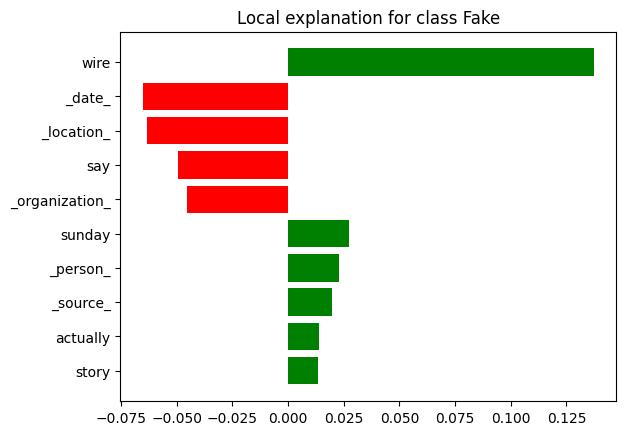

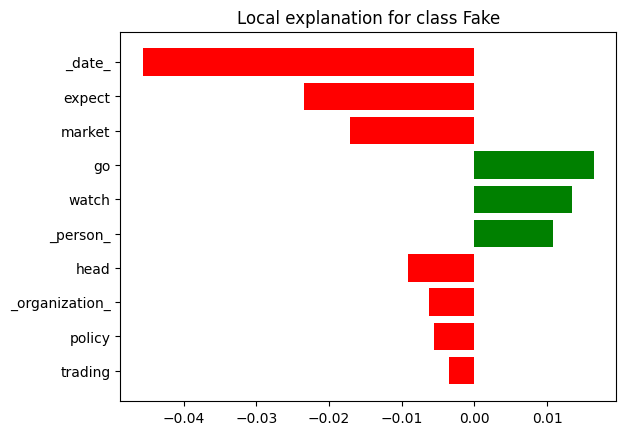

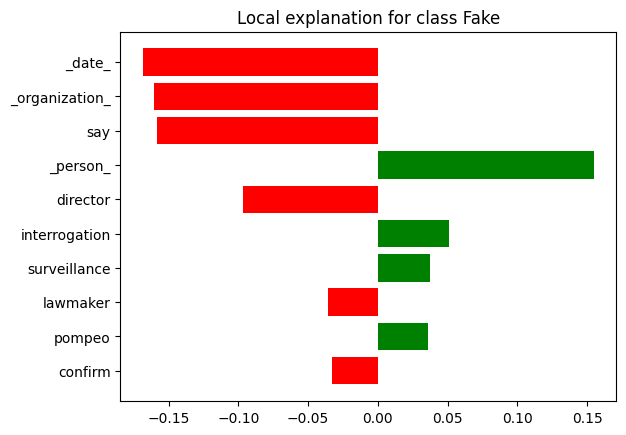

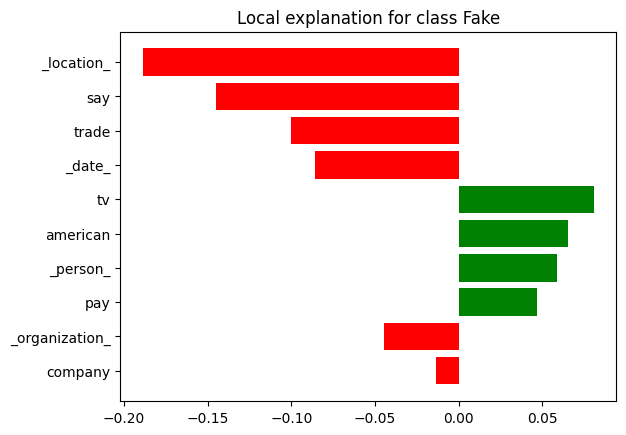

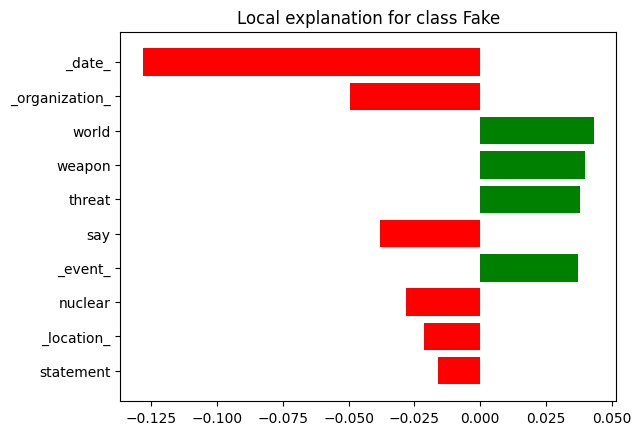

In [ ]:
for idx in misclassified_idxs:
    print(f"\nExplaining misprediction for sample #{idx}")
    text = X_text_series.iloc[idx]

    # Create wrapper with correct sample index
    wrapped_model = LimeWrappedModel(
        model=best_model,
        tfidf=tfidf,
        svd=svd,
        numeric_df=numeric_df_test,
        original_index=idx,
    )

    exp = explainer.explain_instance(
        text_instance=text, classifier_fn=wrapped_model.predict_proba, num_features=10
    )
    exp.as_pyplot_figure()

In [45]:
exp.show_in_notebook()

It looks like the model has learned that structured and factual language like date, place, organization entities, or formal speech verbs like "say" often correlates with real news. On the contrary, sensational, emotionally charged or topic specific vocabulary like "weapon", "pay", "watch" can shift the prediction toward fake, perhaps because these words appear disproportionately in fake headlines. However, these aren't always reliable indicators, hence the misclassifications. 

***All features***

We now examine all features after SVD truncation.

In [ ]:
sample_idxs = np.random.choice(len(X_train), size=500, replace=False)

tfidf_sample = tfidf.transform(X_train["clipped"].iloc[sample_idxs])
numeric_sample = X_train[numeric_features].iloc[sample_idxs].values
X_sample_combined = hstack([tfidf_sample, numeric_sample]).toarray()

# Get feature names
text_feature_names = tfidf.get_feature_names_out()
all_feature_names = list(text_feature_names) + numeric_features

# Initialize tabular explainer with subset
explainer = LimeTabularExplainer(
    training_data=X_sample_combined,
    feature_names=all_feature_names,
    class_names=["True", "Fake"],
    mode="classification",
)

In [ ]:
class LimeWrappedTabularModel:
    def __init__(self, model, svd):
        self.model = model
        self.svd = svd

    def predict_proba(self, input_matrix):
        reduced = self.svd.transform(input_matrix)
        return self.model.predict_proba(pd.DataFrame(reduced))


wrapped_model = LimeWrappedTabularModel(model=best_model, svd=svd)


Explaining misprediction for sample #322

Explaining misprediction for sample #605

Explaining misprediction for sample #2256

Explaining misprediction for sample #2320

Explaining misprediction for sample #2382


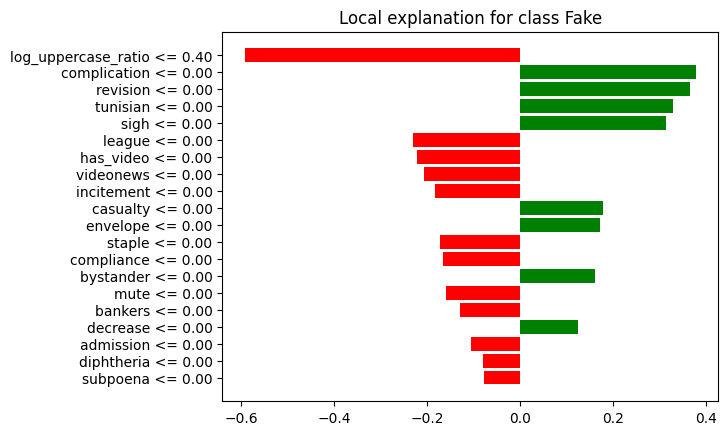

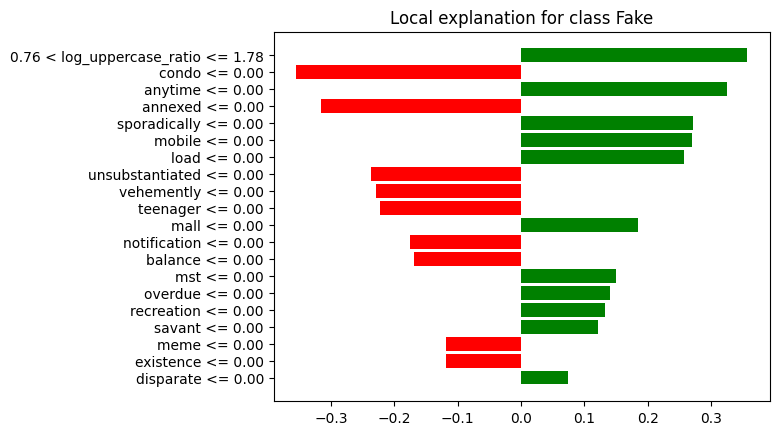

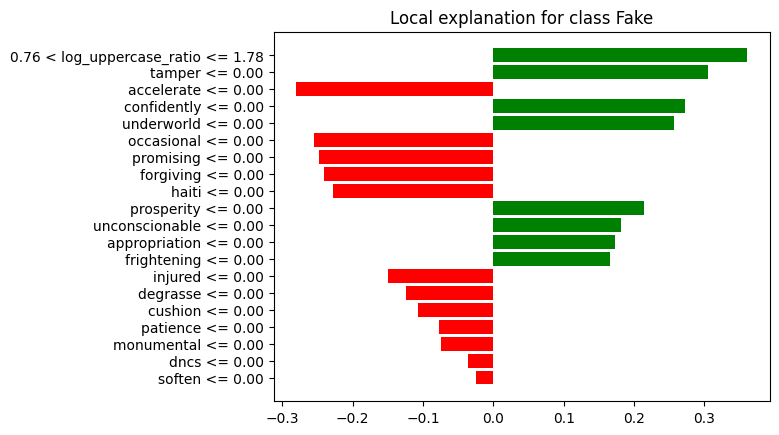

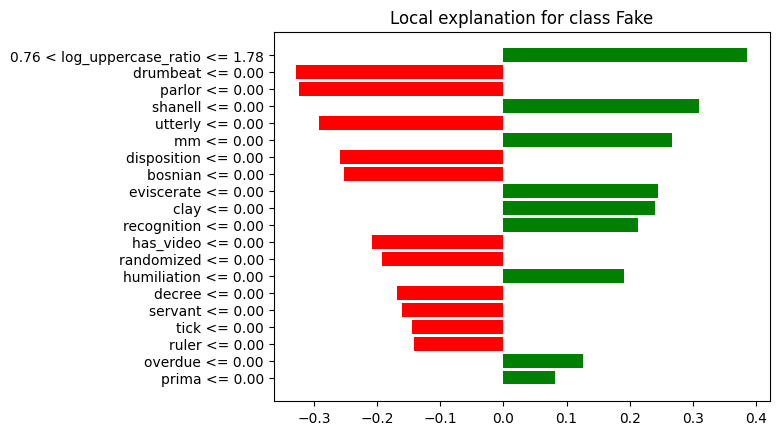

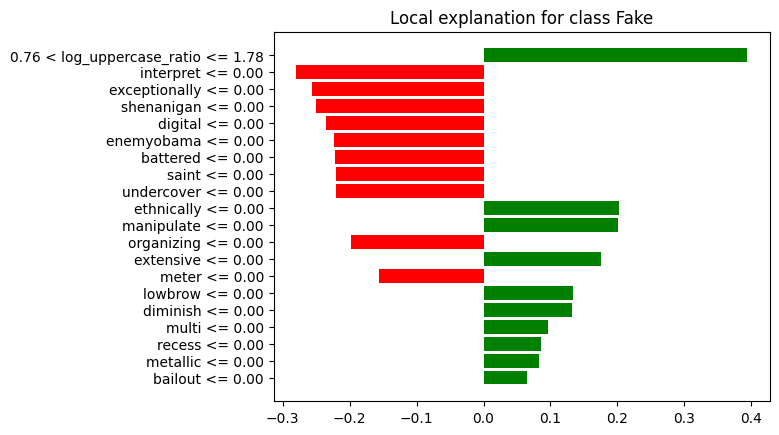

In [ ]:
for idx in misclassified_idxs:
    print(f"\nExplaining misprediction for sample #{idx}")

    instance = X_test_combined.getrow(idx).toarray().flatten()

    exp = explainer.explain_instance(
        data_row=instance, predict_fn=wrapped_model.predict_proba, num_features=20
    )

    exp.as_pyplot_figure()

In [57]:
exp.show_in_notebook()

Extending the analysis to all features, not only clipped text, we can notice that `uppercase ratio` is the most important feature for all the mispredicted news. We see that the words in the list now differ from the analysis we made above. This is likely due to the SVD dimensionality reduction, so the correlation between word and class might be indirect.

### ***6. Test With External Data***

We will now test the best model on the same synthetic dataset used for Heuristic Model, let's see if it is able to generalize more.

In [ ]:
synthetic_data = pd.read_csv("dataset/synthetic_news.csv")

We preprocess the dataset, cleaning and running through features engineering.

In [36]:
nlp = setup_nlp_pipeline()
preprocessed_synth_data = run_full_pipeline(synthetic_data, nlp)

Then we shuffle the dataset.

In [ ]:
preprocessed_synth_data = preprocessed_synth_data.sample(
    frac=1, random_state=SEED
).reset_index(drop=True)

In [38]:
preprocessed_synth_data.head()

fake  title_length  text_length  title_sentiment  text_sentiment  \
0     1            16          514          -0.2500         -0.9846   
1     0            11          732           0.0000         -0.9836   
2     1            10          620          -0.5983         -0.9217   
3     0            10          614           0.0000         -0.9686   
4     0            16          169          -0.6249         -0.7783   

   flesch_kincaid_grade  flesch_reading_ease  clickbait_score  \
0                   9.9                38.08                0   
1                  11.0                29.82                0   
2                  11.2                29.41                1   
3                  11.1                29.52                0   
4                  10.1                37.47                0   

   exclamation_count  question_count  ...  clickbaitiness_score  has_video  \
0                  0               0  ...              0.000000          0   
1                  0               0  ...              0.000000          0   
2                  1               0  ...              0.620736          0   
3                  0               0  ...              0.000000          0   
4                  0               0  ...              0.000000          0   

   has_audio  has_image  has_social  has_authority  \
0          0          0           0              0   
1          0          0           0              0   
2          0          0           0              0   
3          0          0           0              0   
4          0          0           0              0   

                                       combined_text  \
0  Leaked letter shows NATO expansion is a cover-...   
1  bbc Analysts say the Brexit trade issues refle...   
2  Massive protests erupt over Israel-Palestine t...   
3  bbc Analysts say the AI regulations reflects o...   
4  nyt According to officials, the Sri Lanka econ...   

                                          clean_text  \
0  Leaked letter shows NATO expansion is a cover-...   
1  bbc Analysts say the Brexit trade issues refle...   
2  Massive protests erupt over Israel-Palestine t...   
3  bbc Analysts say the AI regulations reflects o...   
4  nyt According to officials, the Sri Lanka econ...   

                                     lemmatized_text  \
0  leak letter show _organization_ expansion cove...   
1  _organization_ _person_ trade issue reflect on...   
2  massive protest erupt _location_ palestine ten...   
3  _organization_ _organization_ regulation refle...   
4  nyt accord official _location_ economic crisis...   

                                             clipped  
0  leak letter show _organization_ expansion cove...  
1  _organization_ _person_ trade issue reflect on...  
2  massive protest erupt _location_ palestine ten...  
3  _organization_ _organization_ regulation refle...  
4  nyt accord official _location_ economic crisis...  

[5 rows x 21 columns]

We then vectorize with TF-IDF.

In [ ]:
X_synth = prep.transform(preprocessed_synth_data)
X_synth_tfidf = tfidf.transform(preprocessed_synth_data["clipped"])
X_synth_combined = hstack([X_synth_tfidf, X_synth[numeric_features].values])
y_synth = preprocessed_synth_data["fake"]

And finally we reduce dimensionality with SVD.

In [40]:
X_synth_svd = svd.transform(X_synth_combined)

Let's have a look at distribution after the whole process.

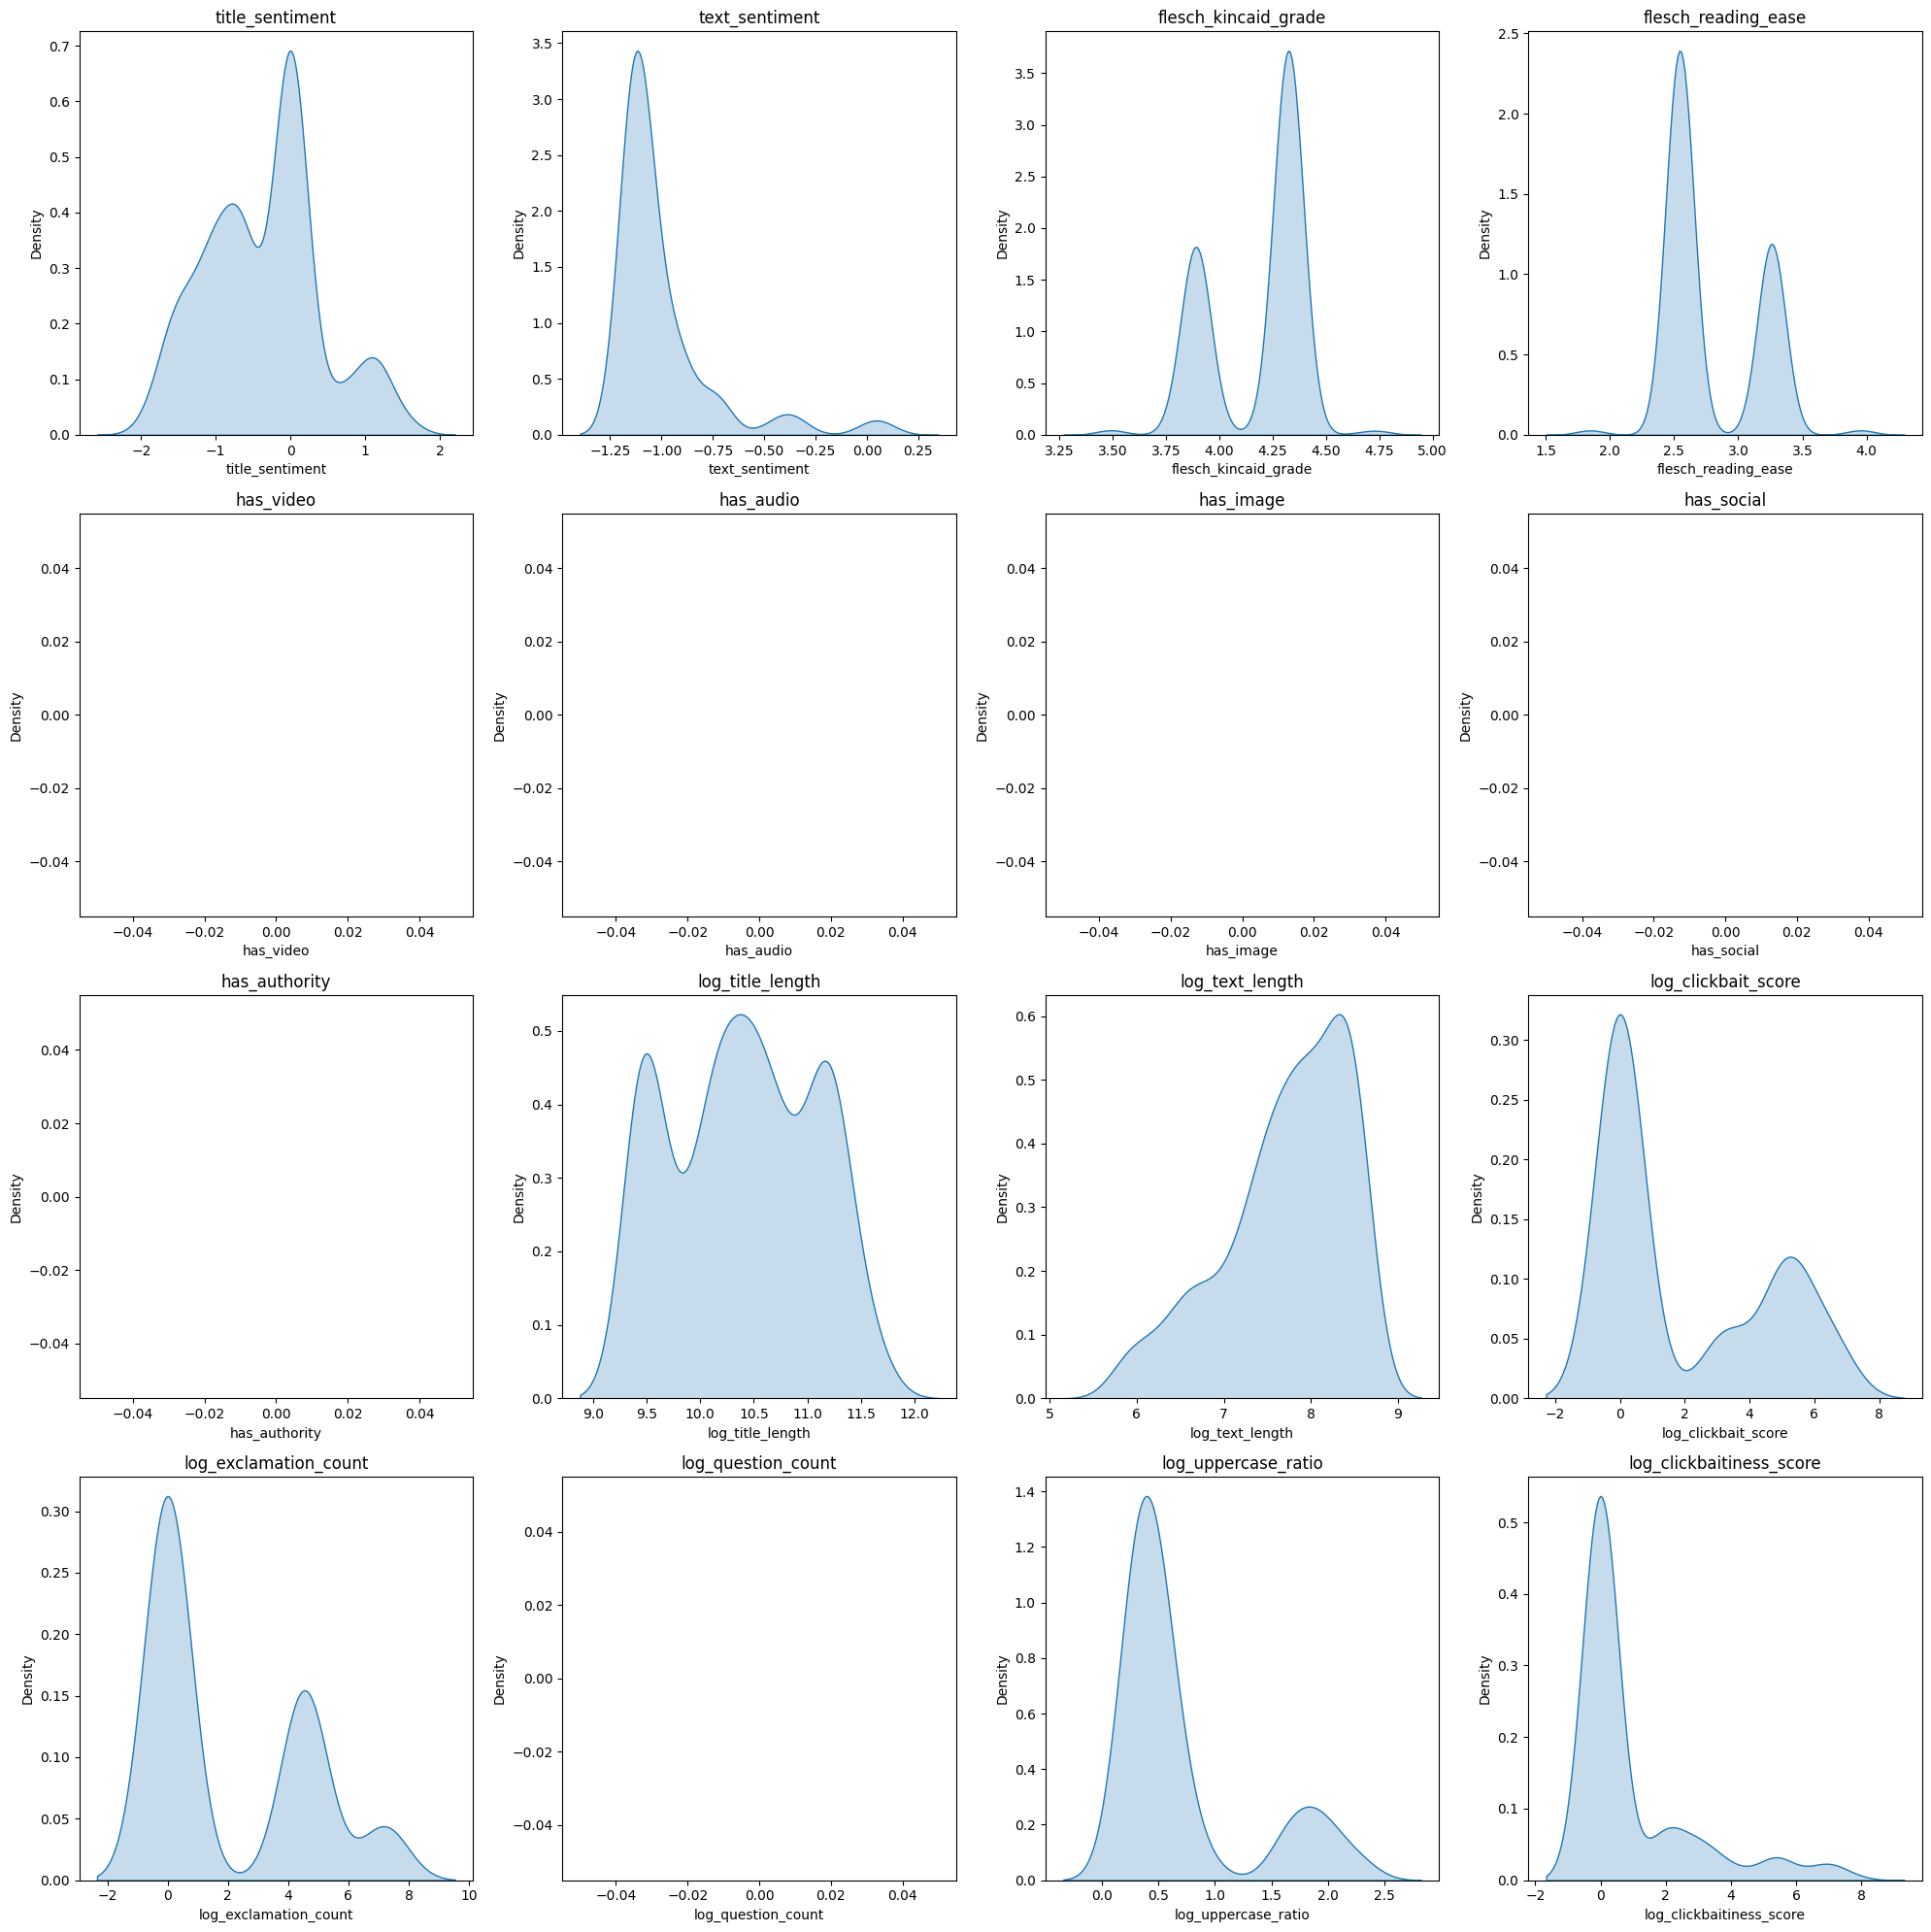

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(X_synth[numeric_features].columns):
    sns.kdeplot(
        X_synth[numeric_features][col], ax=axes[i], fill=True, warn_singular=False
    )
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

It seems the new dataset doesn't have metadata in brackets or multiple question marks, probably some of the features we extracted are peculiar only of this dataset.

Let's now run the Logistic Regression model we have trained to predict the label for these news.

In [ ]:
y_synth_pred = best_model.predict(X_synth_svd)

This is the resulting confusion matrix and metrics.

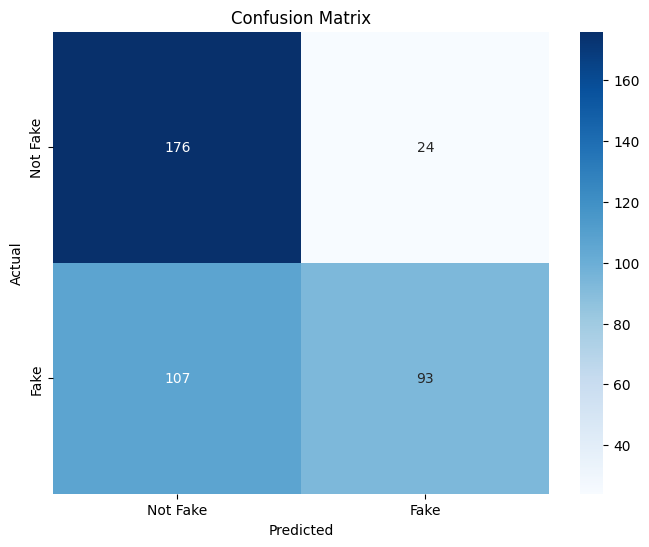

In [ ]:
cm = confusion_matrix(preprocessed_synth_data["fake"], y_synth_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Fake", "Fake"],
    yticklabels=["Not Fake", "Fake"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [43]:
report_dict = classification_report(y_synth, y_synth_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

print("Classification Report:")
display(report_df)

Classification Report:


precision  recall  f1-score  support
0                 0.622   0.880     0.729  200.000
1                 0.795   0.465     0.587  200.000
accuracy          0.672   0.672     0.672    0.672
macro avg         0.708   0.672     0.658  400.000
weighted avg      0.708   0.672     0.658  400.000

It looks like the `fake news` predictors we had extracted in the original dataset are not applyable to this one. The results are far off from the previous ones and quite similar to the Heuristic model's results.